# Qiskit Runtime makes circuit transpilation & error mitigation easy

In [1]:
from qiskit import *
from qiskit_ibm_provider import IBMProvider

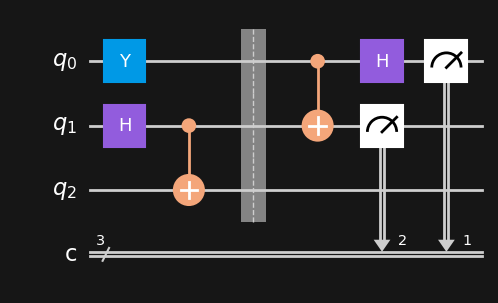

In [41]:
# Create circuit
qc = QuantumCircuit(3,3)

qc.y(0)
qc.h(1)
qc.cx(1, 2)
qc.barrier()

qc.cx(0, 1)
qc.h(0)
qc.measure([0,1],[1,2])

qc.draw()


In [3]:
provider=IBMProvider()

In [4]:
backend=provider.get_backend('ibm_brisbane')

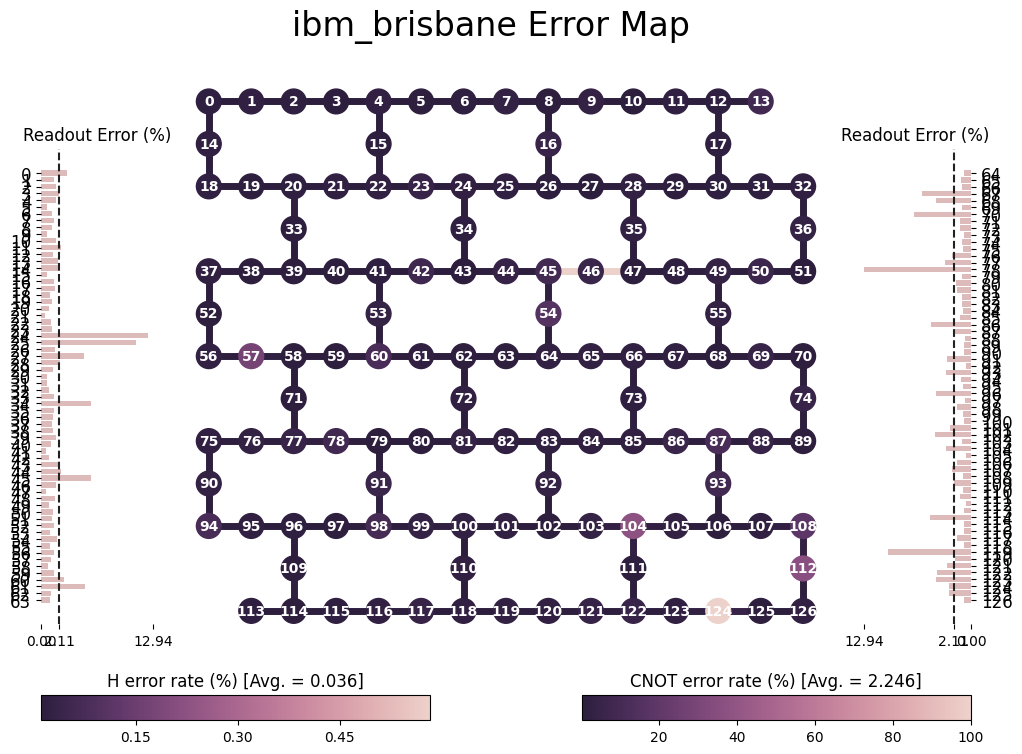

In [19]:
from qiskit.visualization import plot_error_map
plot_error_map(backend)

# Run through Qiskit Runtime

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session

In [6]:
runtime_service = QiskitRuntimeService()

In [42]:
runtime_backend = runtime_service.backend('ibm_brisbane')

In [43]:
sampler=Sampler(runtime_backend)

## Use Runtime defaults for remotely transpiled, mitigated runs

In [9]:
job_sampler = sampler.run(qc)

In [19]:
job_sampler.status()

<JobStatus.DONE: 'job has successfully run'>

In [20]:
job_sampler.inputs

{'circuits': (<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x284f7599bb0>,),
 'parameters': [ParameterView([])],
 'circuit_indices': [0],
 'parameter_values': ((),),
 'transpilation_settings': {'skip_transpilation': False,
  'initial_layout': None,
  'layout_method': None,
  'routing_method': None,
  'approximation_degree': None,
  'optimization_settings': {'level': 3},
  'coupling_map': None,
  'basis_gates': None},
 'resilience_settings': {'noise_amplifier': 'TwoQubitAmplifier',
  'noise_factors': (1, 3, 5),
  'extrapolator': 'LinearExtrapolator',
  'level': 1},
 'run_options': {'shots': 4000,
  'init_qubits': True,
  'noise_model': None,
  'seed_simulator': None}}

In [21]:
job_sampler.inputs['transpilation_settings']['optimization_settings']

{'level': 3}

In [22]:
sampler.session._active

True

In [23]:
sampler.session.close()

## Change Options

In [11]:
from qiskit_ibm_runtime import Options

In [12]:
Options._DEFAULT_OPTIMIZATION_LEVEL

3

In [13]:
different_options = Options()

In [14]:
different_options.optimization_level=2

different_options.execution.shots=1789

In [15]:
sampler_with_options=Sampler(session='ibm_brisbane',options=different_options)

In [16]:
job_sampler_options=sampler_with_options.run(qc)

In [24]:
job_sampler_options.status()

<JobStatus.DONE: 'job has successfully run'>

In [25]:
sampler_options_result=job_sampler_options.result()
sampler_options_result

SamplerResult(quasi_dists=[{0: 0.2508317568547381, 2: 0.24349912494359, 4: 0.25018797189699027, 6: 0.25548114630468155}], metadata=[{'shots': 1789, 'readout_mitigation_overhead': 1.2120218515205634, 'readout_mitigation_time': 0.10029714927077293}])

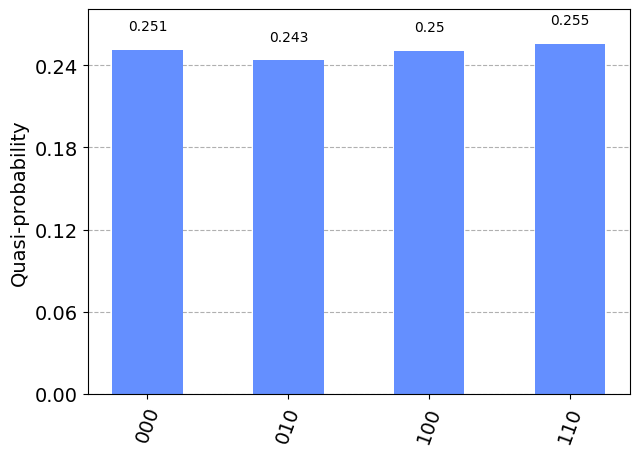

In [26]:
from qiskit.visualization import plot_distribution
plot_distribution(sampler_options_result.quasi_dists[0].binary_probabilities())

In [29]:
different_options.__dict__

{'optimization_level': 2,
 'resilience_level': None,
 'max_execution_time': None,
 'transpilation': TranspilationOptions(skip_transpilation=False, initial_layout=None, layout_method=None, routing_method=None, approximation_degree=None),
 'resilience': ResilienceOptions(noise_amplifier='TwoQubitAmplifier', noise_factors=(1, 3, 5), extrapolator='LinearExtrapolator'),
 'execution': ExecutionOptions(shots=1789, init_qubits=True),
 'environment': EnvironmentOptions(log_level='WARNING', callback=None, job_tags=[]),
 'simulator': SimulatorOptions(noise_model=None, seed_simulator=None, coupling_map=None, basis_gates=None)}

# Error Mitigation

In [160]:
Options._DEFAULT_RESILIENCE_LEVEL

1

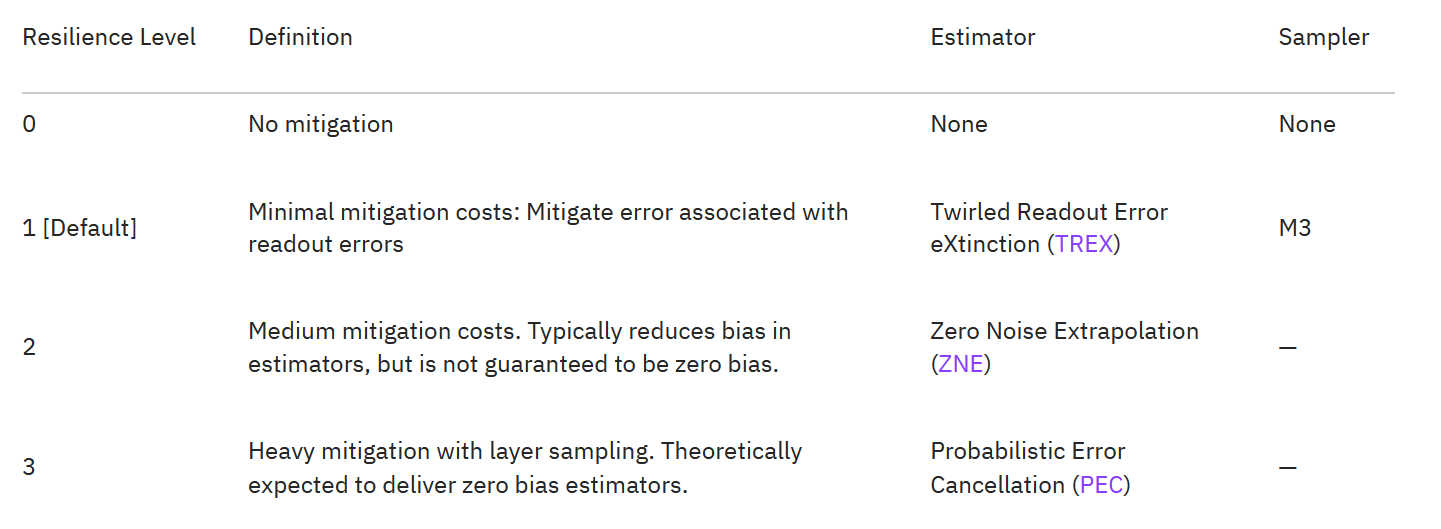

https://qiskit.org/documentation/partners/qiskit_ibm_runtime/how_to/error-mitigation.html

# Resilience Level 1 (TREX & M3)

## Matrix-free Measurement Mitigation (M3)

M3 gets around the explicit construction of the full A-matrix via a information preserving truncation step that reduces the dimensionality to be equal to the number of unique bit-strings in the noisy output distribution. If the number of unique bit-strings is itself too large for explicit matrix construction then M3 will exploit the structure of the A-matrix to efficiently solve the linear system via matrix-free iterative methods. 

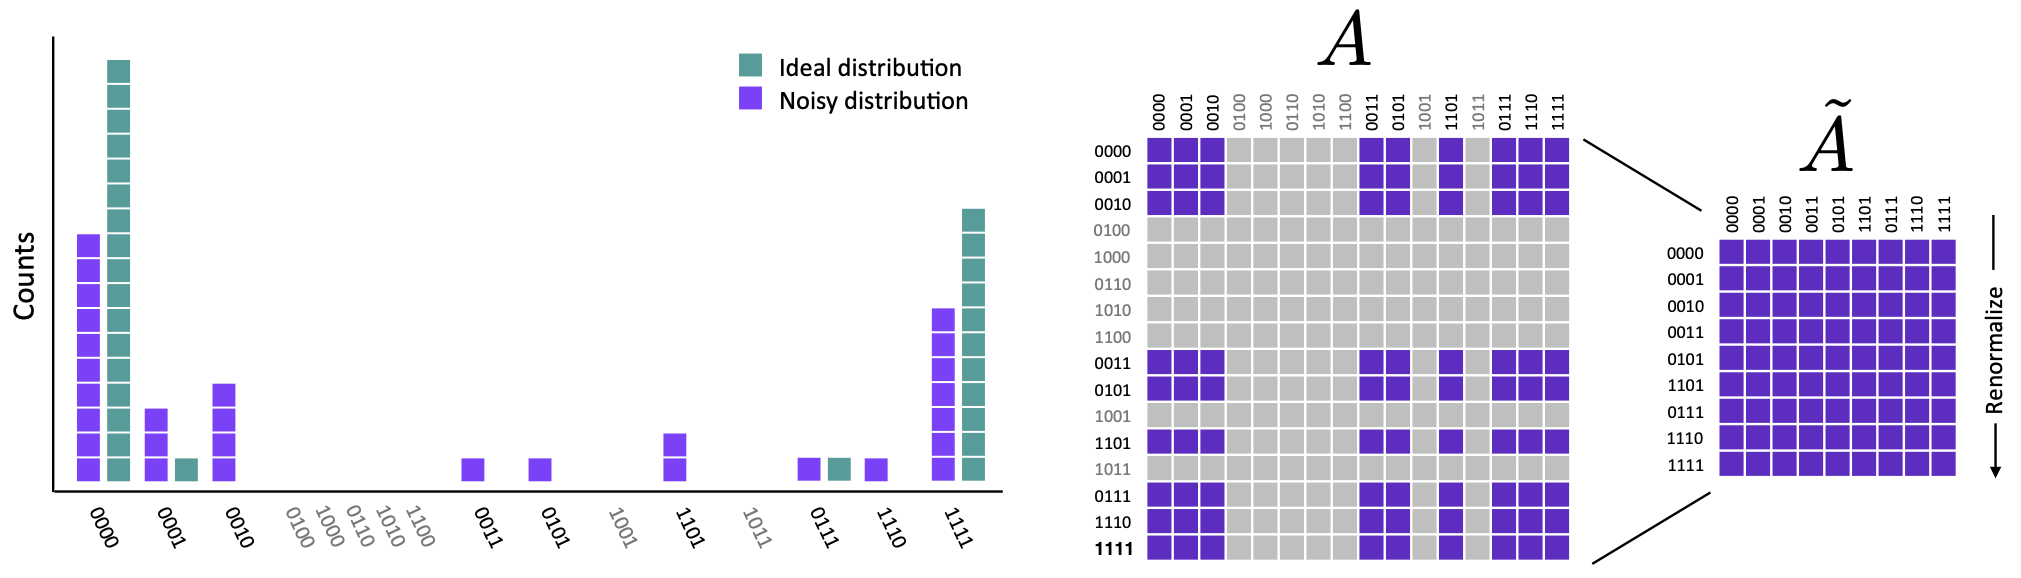

Paul D. Nation et al, PRX Quantum 2, 040326 (2021)

## Twirled readout error extinction
Twirled readout error extinction (T-REx) uses a technique known as Pauli twirling to reduce the noise introduced during the process of quantum measurement. This technique assumes no specific form of noise, which **makes it very general and effective**.

The method randomizes the output channel by uniformly applying random Pauli bit flips prior to measurement, which are tracked and used in analysis. This randomization transforms the action of an arbitrary noise map into a single multiplicative factor per Pauli observable. The multiplicative factors can be measured directly. By dividing out this factor, the bias-free mitigated Pauli expectation value is obtained.

#### Overall workflow
1. Acquire data for the zero state with randomized bit flips (Pauli X before measurement)
2. Acquire data for the desired (noisy) state with randomized bit flips (Pauli X before measurement)
3. Compute & divide the special function for each data set to return mitigated estimate of expectation value

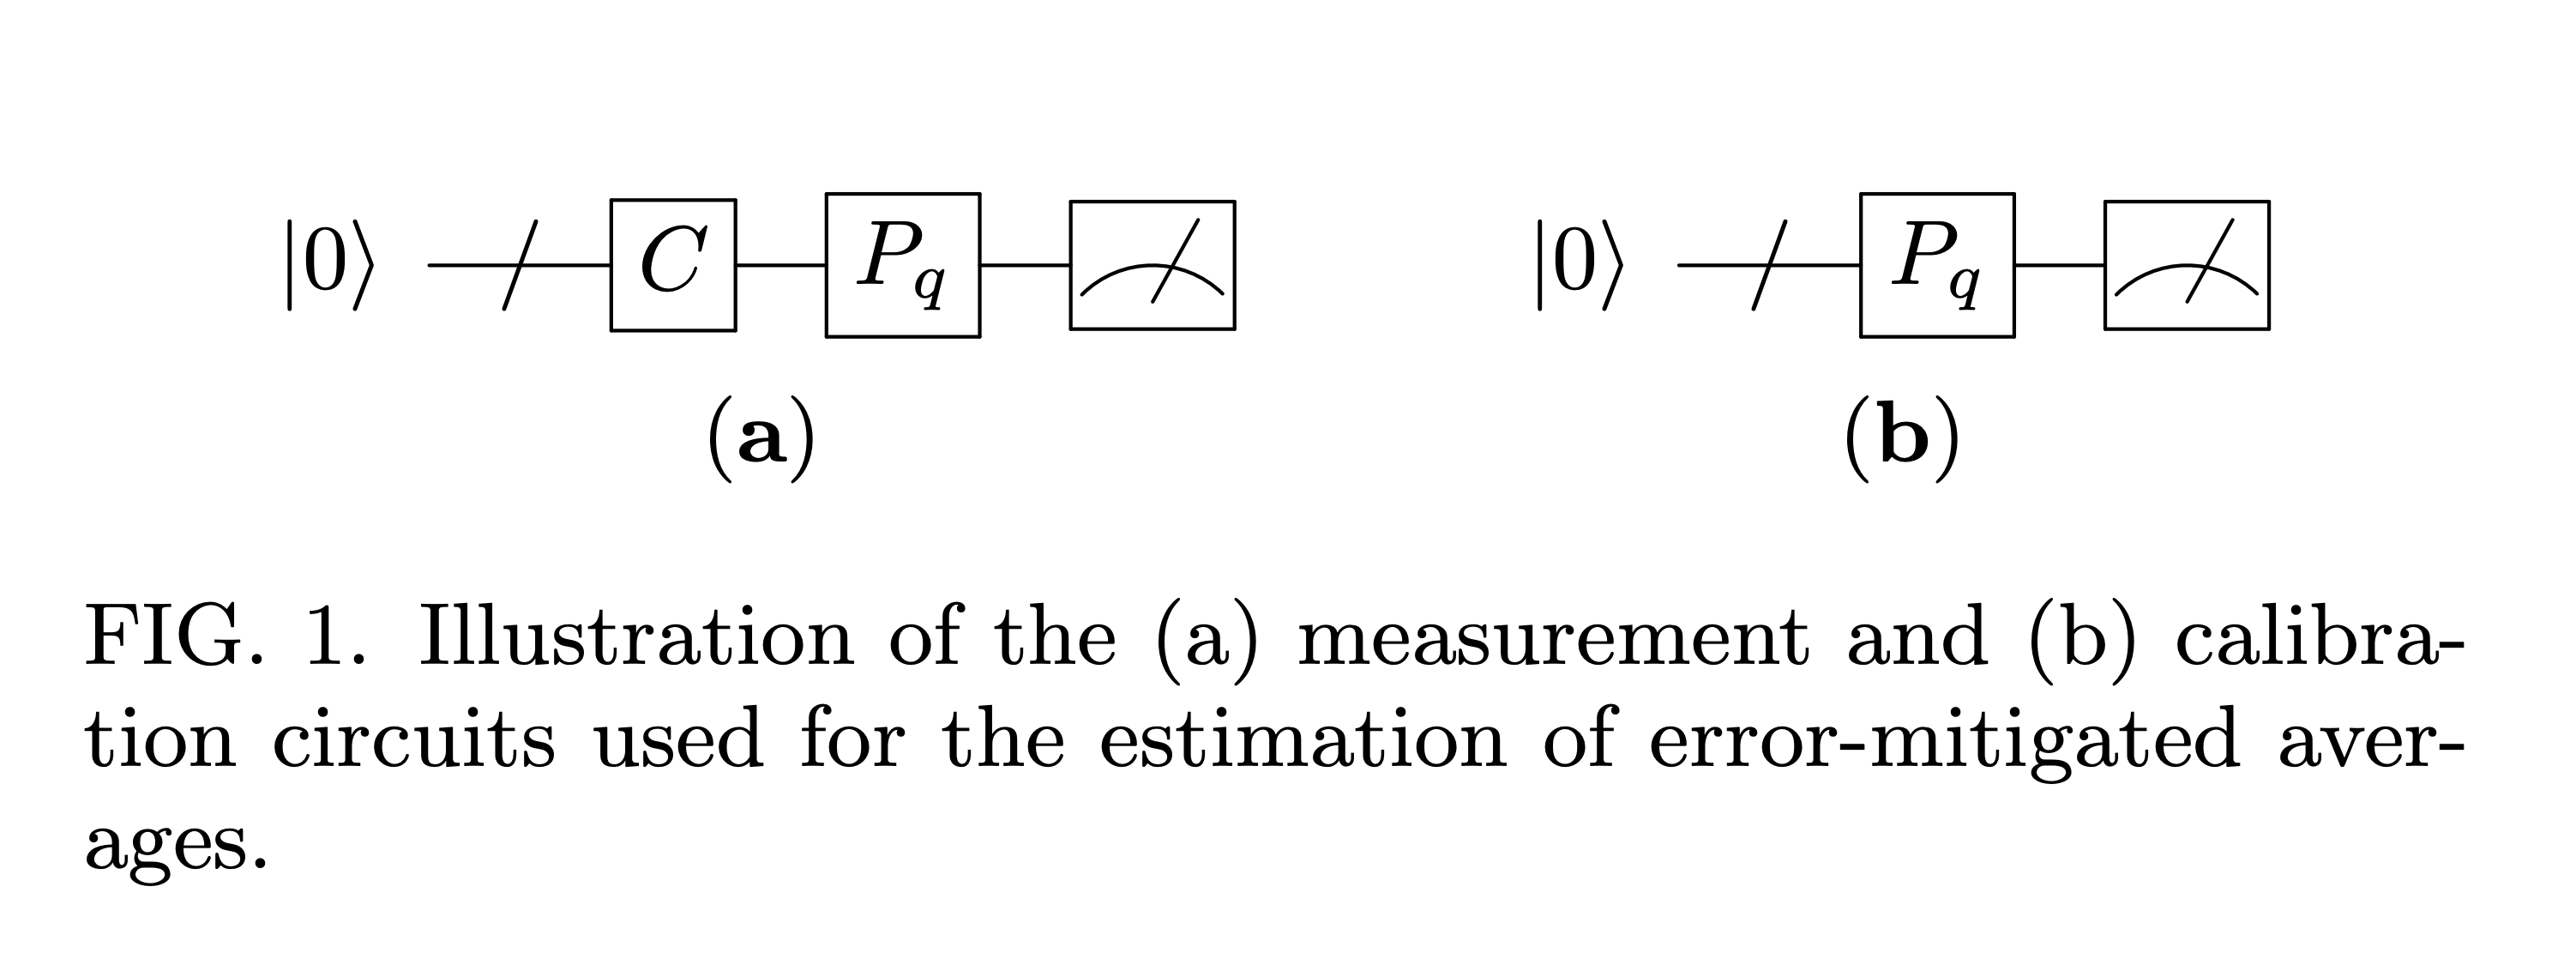
van den Berg et al, [Phys. Rev. A 105, 032620](https://arxiv.org/abs/2012.09738) (2022)

## TREX example: Trotter circuit

Trotter circuit with 1 Trotter steps


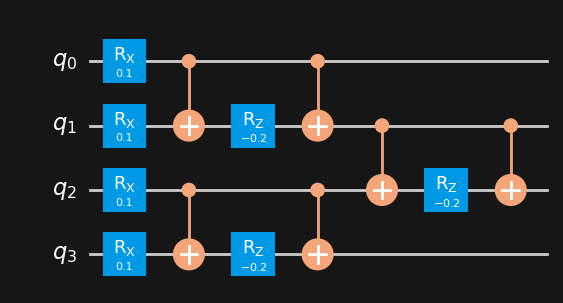

Trotter circuit with 3 Trotter steps


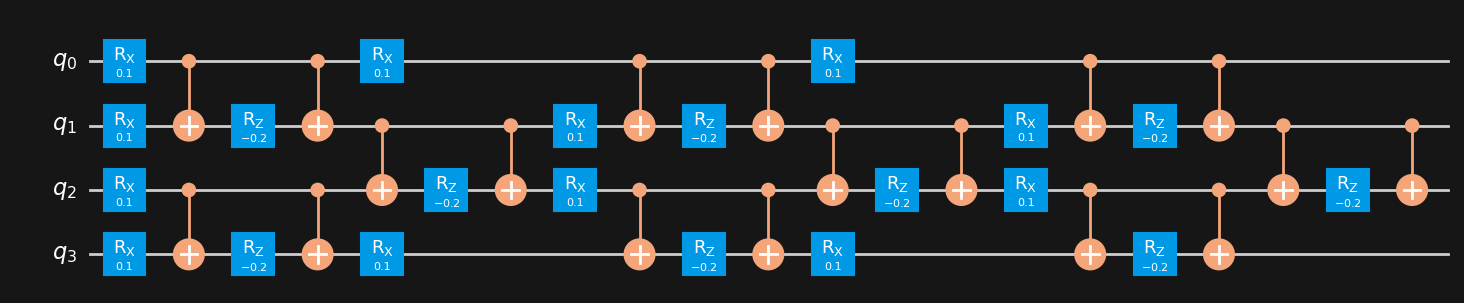

Trotter circuit with 5 Trotter steps


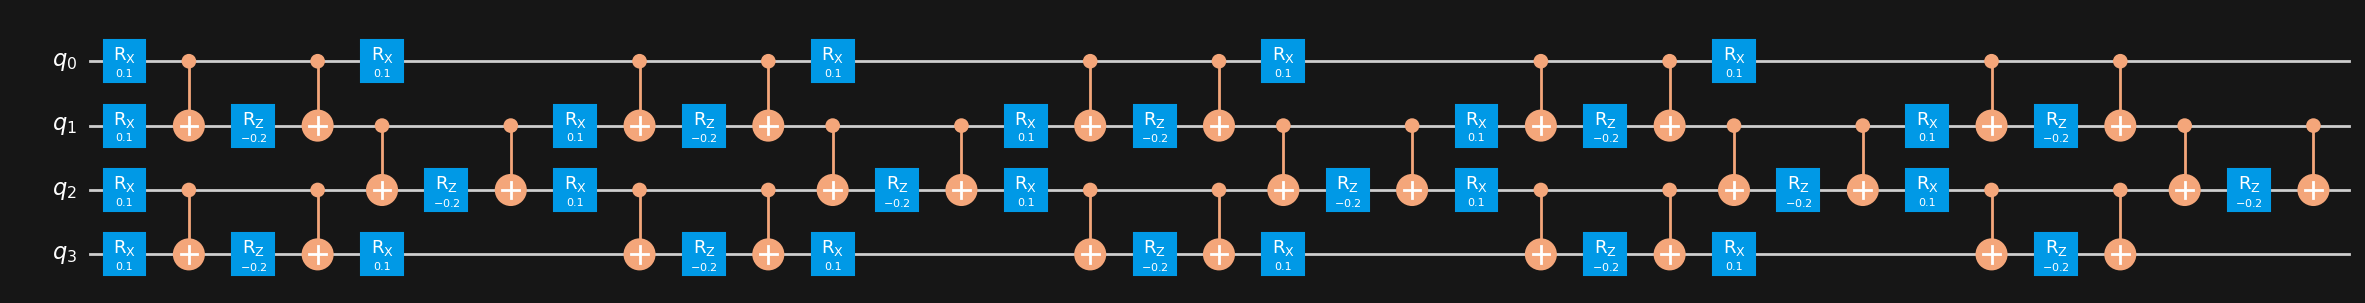

In [64]:
from qiskit.quantum_info import SparsePauliOp

backend_simulator = "ibmq_qasm_simulator"
backend = "ibm_canberra"

qubits = 4
trotter_layer = QuantumCircuit(qubits)
trotter_layer.rx(0.1, range(qubits))
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.rz(-0.2, [1, 3])
trotter_layer.cx(0, 1)
trotter_layer.cx(2, 3)
trotter_layer.cx(1, 2)
trotter_layer.rz(-0.2, 2)
trotter_layer.cx(1, 2)

trotter_circuit_list = []
for i in [1,3,5]:
    trotter_circuit = QuantumCircuit(qubits)
    for _ in range(i):
        trotter_circuit = trotter_circuit.compose(trotter_layer)
    trotter_circuit_list.append(trotter_circuit)
    print(f"Trotter circuit with {i} Trotter steps")
    display(trotter_circuit.draw(fold=-1,idle_wires=False))

obs = SparsePauliOp("Z" * qubits)
obs_list = [obs] * len(trotter_circuit_list)

In [65]:
import numpy as np
options = Options()
options.execution.shots = 1789
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No mitigation

with Session(service=runtime_service, backend=backend_simulator) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=trotter_circuit_list, observables=obs_list)

In [66]:
from qiskit.quantum_info import hellinger_fidelity

In [67]:
job_sim.result().__dict__

{'values': array([0.98099497, 0.85131358, 0.67132476]),
 'metadata': [{'variance': 0.037648870293305325, 'shots': 1789},
  {'variance': 0.27526518338732964, 'shots': 1789},
  {'variance': 0.5493230633387503, 'shots': 1789}]}

In [68]:
expvals_ideal = job_sim.result().values
expvals_ideal_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_sim.result().metadata
]
std_error_ideal = np.sqrt(expvals_ideal_variance)

In [69]:
options = Options()
options.execution.shots = 1789
options.optimization_level = 0  # No optimization
options.resilience_level = 0  # No error mitigation

with Session(service=runtime_service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    job = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print(job.result())

expvals_unmit = job.result().values
expvals_unmit_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job.result().metadata
]
std_error_unmit = np.sqrt(expvals_unmit_variance)

EstimatorResult(values=array([0.66573505, 0.30799329, 0.1548351 ]), metadata=[{'variance': 0.556796846513427, 'shots': 1789}, {'variance': 0.9051401318722796, 'shots': 1789}, {'variance': 0.9760260907520995, 'shots': 1789}])


In [70]:
options = Options()
options.resilience_level = 1  # T-REx
options.optimization_level = 3
options.execution.shots = 1789

with Session(service=runtime_service, backend=backend) as session:
    estimator = Estimator(session=session, options=options)
    job_trex = estimator.run(circuits=trotter_circuit_list, observables=obs_list)
    print(job_trex.result())

expvals_unmit_trex = job_trex.result().values
expvals_unmit_trex_variance = [
    metadata["variance"] / metadata["shots"] for metadata in job_trex.result().metadata
]
std_error_trex = np.sqrt(expvals_unmit_trex_variance)

EstimatorResult(values=array([0.84029396, 0.62524023, 0.54203262]), metadata=[{'variance': 0.9446635288703469, 'shots': 1792, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 1.3303648632732266, 'shots': 1792, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}, {'variance': 1.3569581035533187, 'shots': 1792, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}])


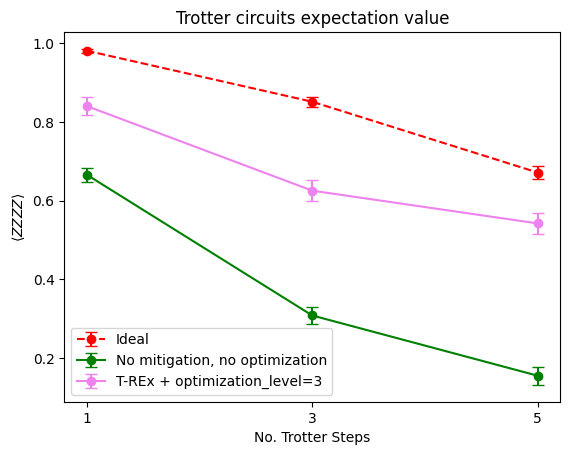

In [71]:
from matplotlib import pyplot as plt
ticklist=[1,3,5]

plt.title("Trotter circuits expectation value")
plt.errorbar(
    ticklist,
    expvals_ideal,
    std_error_ideal,
    fmt="o",
    linestyle="--",
    capsize=4,
    c="red",
    label="Ideal",
)
plt.errorbar(
    ticklist,
    expvals_unmit,
    std_error_unmit,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="green",
    label="No mitigation, no optimization",
)
plt.errorbar(
    ticklist,
    expvals_unmit_trex,
    std_error_trex,
    fmt="o",
    linestyle="-",
    capsize=4,
    c="violet",
    label="T-REx + optimization_level=3",
)

plt.ylabel(f"$\langle ZZZZ \\rangle$")
plt.xlabel("No. Trotter Steps")
plt.xticks(ticklist)
plt.legend()
plt.show()

## Exemplary circuit: Hadamard ladder

In [76]:
backend='ibm_canberra'

In [73]:
from qiskit import QuantumCircuit

def cntrl_hadamard_ladder(N, measurements=False):
    qc = QuantumCircuit(N)

    qc.x(range(N))
    qc.h(range(N))

    for kk in range(N // 2, 0, -1):
        qc.ch(kk, kk - 1)
    for kk in range(N // 2, N - 1):
        qc.ch(kk, kk + 1)
    if measurements:
        qc.measure_all()
    return qc

In [74]:
from qiskit.quantum_info import SparsePauliOp

N = 6
qc = cntrl_hadamard_ladder(N)
oper = SparsePauliOp.from_list([('Z'* N, 1)])

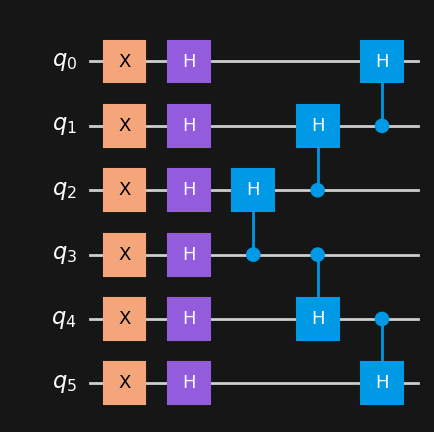

In [75]:
qc.draw()

In [49]:
suppression_jobs = []
with Session(backend=backend):
    estimator = Estimator()
    suppression_jobs.append(estimator.run(qc, oper, shots=1e4, optimization_level=0,
                                         resilience_level=0))
    suppression_jobs.append(estimator.run(qc, oper, shots=1e4, optimization_level=3,
                                         resilience_level=0))

In [45]:
with Session(backend='ibmq_qasm_simulator'):
    estimator = Estimator()
    sim_job=estimator.run(qc, oper, shots=1e4)

In [50]:
#ideal expectation value of Hadamard ladder circuit
sim_job.result()

EstimatorResult(values=array([0.4456]), metadata=[{'variance': 0.80144064, 'shots': 10000}])

In [43]:
suppression_jobs[0].result()

EstimatorResult(values=array([0.2872]), metadata=[{'variance': 0.91751616, 'shots': 10000}])

In [44]:
suppression_jobs[1].result()

EstimatorResult(values=array([0.3504]), metadata=[{'variance': 0.87721984, 'shots': 10000}])

In [132]:
with Session(backend=backend):
    estimator = Estimator()
    sampler = Sampler()
    mitigation_expval = estimator.run(qc, oper, shots=1e4) #running with default optimization_level, resilience_level parameters
    mitigation_quasi = sampler.run(qc.measure_all(inplace=False), shots=1e4)

In [202]:
mitigation_expval.result()

EstimatorResult(values=array([0.50076797]), metadata=[{'variance': 2.437886122595665, 'shots': 10000, 'readout_mitigation_num_twirled_circuits': 16, 'readout_mitigation_shots_calibration': 8192}])

In [92]:
# Get sampled expectation value function
from qiskit.result import sampled_expectation_value
sampled_expectation_value(mitigation_quasi.result().quasi_dists[0], oper)

0.4000269300578102

## Resilience Level 2 - ZNE

## Zero Noise Extrapolation (ZNE)

Zero noise extrapolation (ZNE) works by first amplifying the noise in the circuit that is preparing the desired quantum state, obtaining measurements for several different levels of noise, and using those measurements to infer the noiseless result. 

#### Overall workflow
1. Amplify circuit noise for several noise factors
2. Run every noise amplified circuit
3. Extrapolate back to the zero noise limit

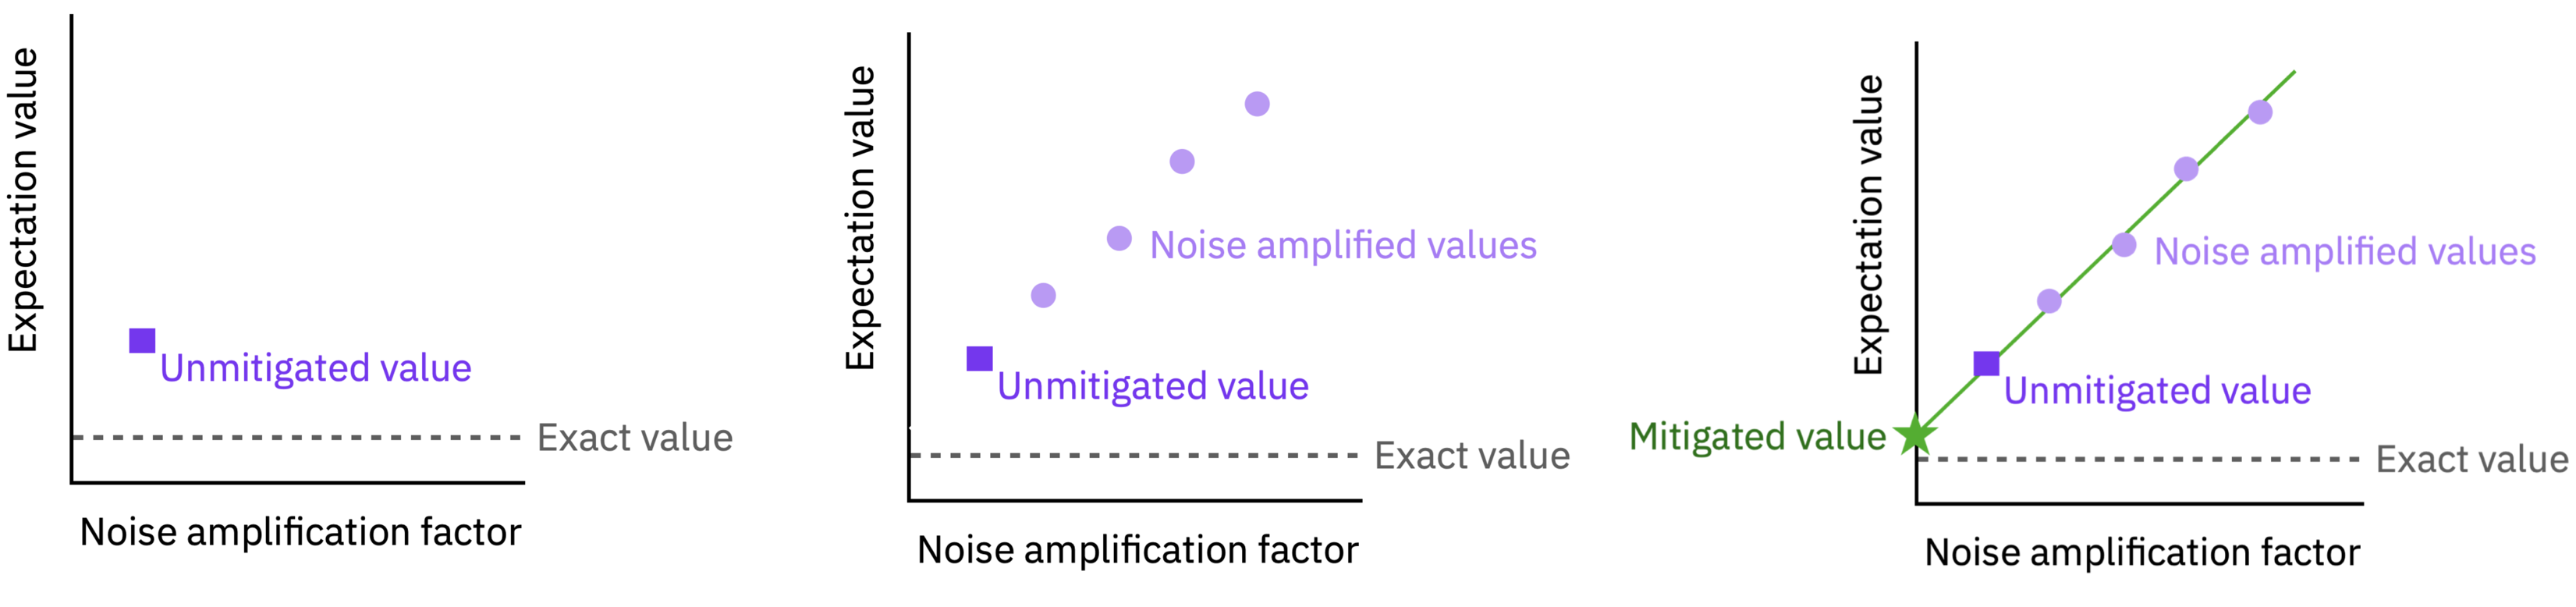

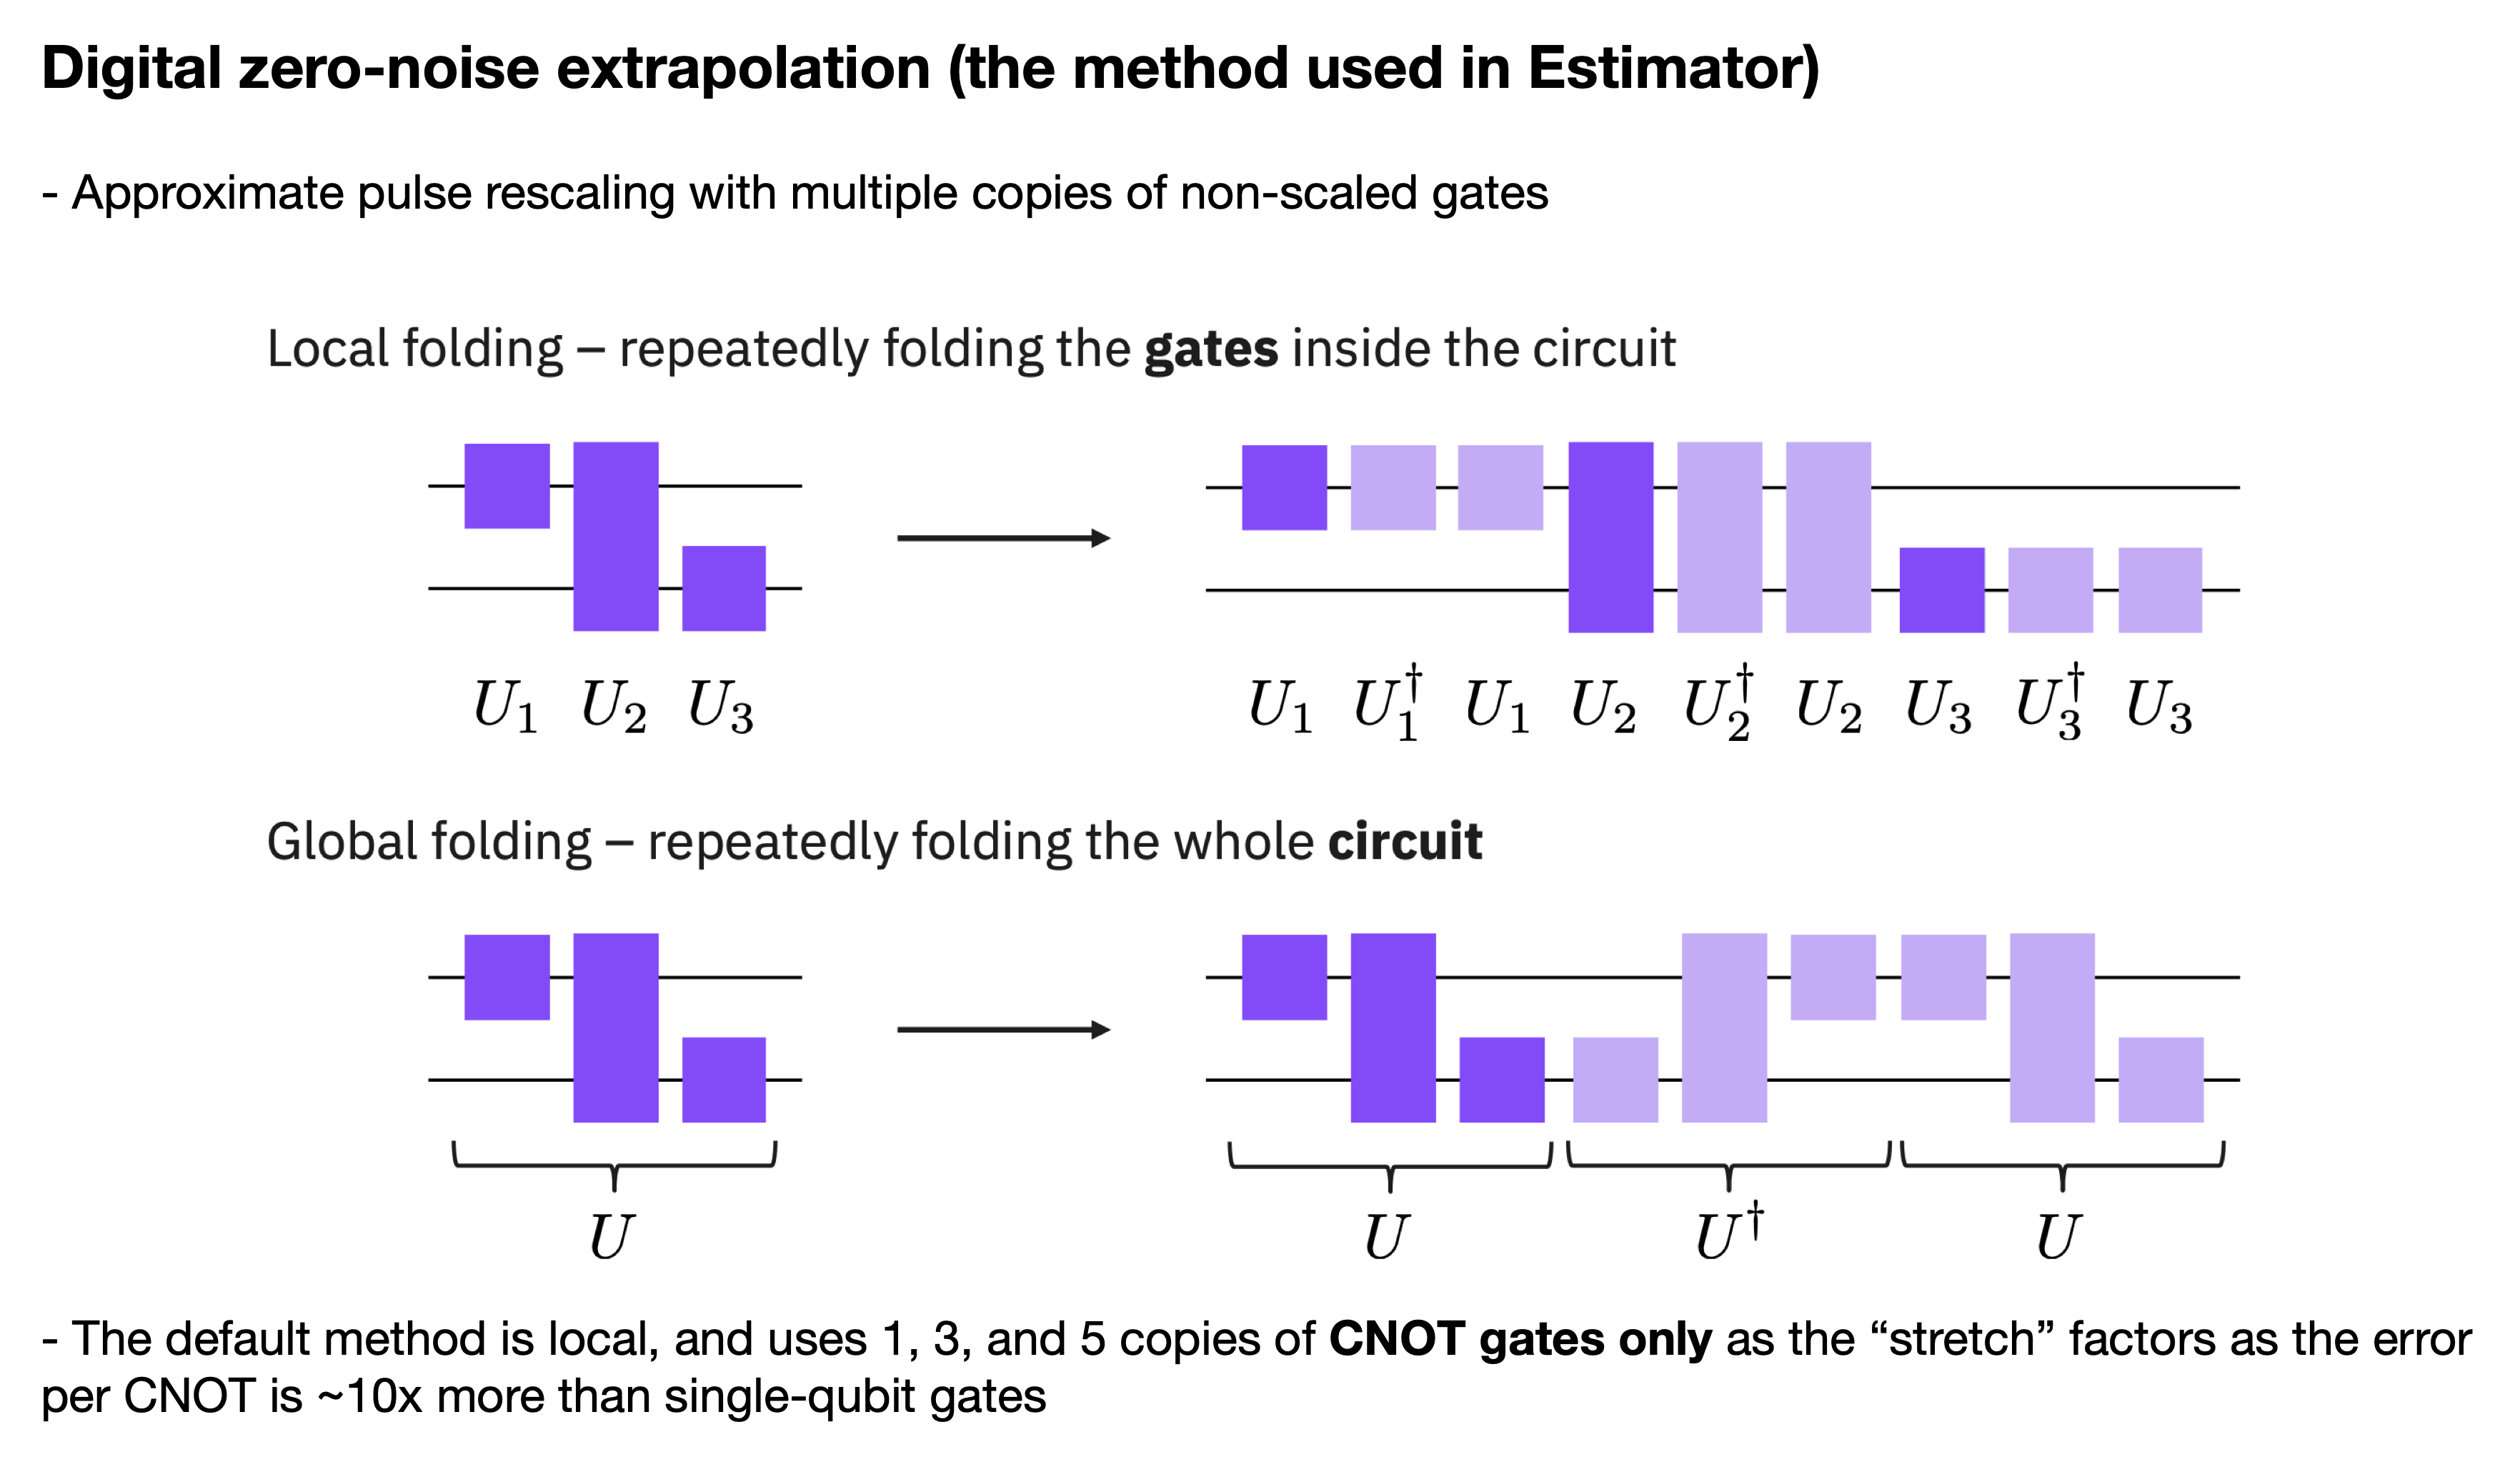

In [20]:
with Session(backend=backend):
    estimator = Estimator()
    # resilience_level=2 for ZNE
    zne_job = estimator.run(qc, oper, shots=int(1e4), resilience_level=2)

In [23]:
zne_job.result().values[0]

0.37488333333333335

In [18]:
zne_job.result().metadata[0]

{'zne': {'noise_amplification': {'noise_amplifier': "<TwoQubitAmplifier:{'noise_factor_relative_tolerance': 0.01, 'random_seed': None, 'sub_folding_option': 'from_first'}>",
   'noise_factors': [1, 3, 5],
   'values': [-0.0032, -0.0064, 0.0032],
   'variance': [0.99998976, 0.99995904, 0.99998976],
   'shots': [10000, 10000, 10000]},
  'extrapolation': {'extrapolator': 'LinearExtrapolator'}}}

#

In [77]:
from qiskit.quantum_info import SparsePauliOp

hadamamard_ladder_sim={}

for N in [4,6,8,10,12]:
    qc = cntrl_hadamard_ladder(N)
    oper = SparsePauliOp.from_list([('Z'* N, 1)])
    hadamamard_ladder_sim[N] = {}
    with Session(backend=backend):
        estimator = Estimator()
        hadamamard_ladder_sim[N]['level_zero']=estimator.run(qc, oper, shots=1e4, optimization_level=0,
                                         resilience_level=0)
        hadamamard_ladder_sim[N]['res_level_one']=estimator.run(qc, oper, shots=1e4)
        hadamamard_ladder_sim[N]['res_level_two']=estimator.run(qc, oper, shots=1e4,resilience_level=2)

In [78]:
zero_jobs = [hadamamard_ladder_sim[x]['level_zero'] for x in [4,6,8,10,12]]
one_jobs = [hadamamard_ladder_sim[x]['res_level_one'] for x in [4,6,8,10,12]]
two_jobs = [hadamamard_ladder_sim[x]['res_level_two'] for x in [4,6,8,10,12]]

In [79]:
zero_vals = [job.result().values[0] for job in zero_jobs]
one_vals = [job.result().values[0] for job in one_jobs]
two_vals = [job.result().values[0] for job in two_jobs]

In [80]:
zero_vals_std=[np.sqrt(metadata[0]["variance"] / metadata[0]["shots"]) for metadata in list(map(lambda x: x.result().metadata,zero_jobs))]
one_vals_std=[np.sqrt(metadata[0]["variance"] / metadata[0]["shots"]) for metadata in list(map(lambda x: x.result().metadata,one_jobs))]
two_vals_std=[np.sqrt(np.mean(metadata[0]['zne']['noise_amplification']["variance"]) / metadata[0]['zne']['noise_amplification']['shots'][0]) for metadata in list(map(lambda x: x.result().metadata,two_jobs))]

In [81]:
hadamamard_ladder_sim={}

for N in [4,6,8,10,12]:
    qc = cntrl_hadamard_ladder(N)
    oper = SparsePauliOp.from_list([('Z'* N, 1)])
    with Session(backend='ibmq_qasm_simulator'):
        estimator = Estimator()
        hadamamard_ladder_sim[N]=estimator.run(qc, oper, shots=1e4)

In [82]:
sim_jobs = [hadamamard_ladder_sim[x] for x in [4,6,8,10,12]]
sim_vals = [job.result().values[0] for job in sim_jobs]
sim_vals_std=[np.sqrt(metadata[0]["variance"] / metadata[0]["shots"]) for metadata in list(map(lambda x: x.result().metadata,sim_jobs))]

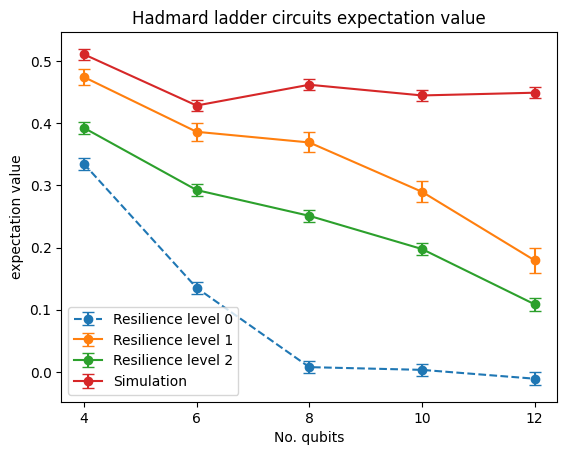

In [83]:
from matplotlib import pyplot as plt
ticklist=[4,6,8,10,12]

plt.title("Hadmard ladder circuits expectation value")
plt.errorbar(
    ticklist,
    zero_vals,
    zero_vals_std,
    fmt="o",
    linestyle="--",
    capsize=4,
    label="Resilience level 0",
)
plt.errorbar(
    ticklist,
    one_vals,
    one_vals_std,
    fmt="o",
    linestyle="-",
    capsize=4,
    label="Resilience level 1",
)
plt.errorbar(
    ticklist,
    two_vals,
    two_vals_std,
    fmt="o",
    linestyle="-",
    capsize=4,
    label="Resilience level 2",
)
plt.errorbar(
    ticklist,
    sim_vals,
    sim_vals_std,
    fmt="o",
    linestyle="-",
    capsize=4,
    label="Simulation",
)

plt.ylabel(f"expectation value")
plt.xlabel("No. qubits")
plt.xticks(ticklist)
plt.legend()
plt.show()

## Application: Classify by a Quantum Neural Network

## Classification

We prepare a simple classification dataset to illustrate the following algorithms.

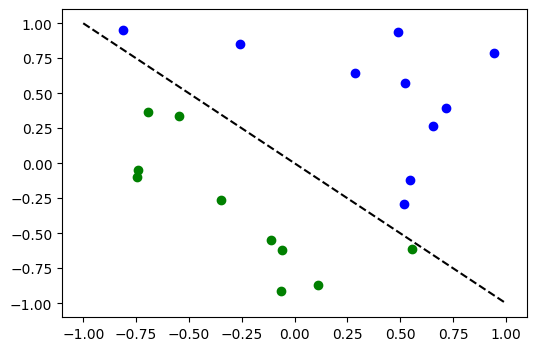

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with a `SamplerQNN`

Next we show how a `SamplerQNN` can be used for classification within a `NeuralNetworkClassifier`. The underlying `Sampler` primitive returns quasi-probability distributions of bit strings and we just need to define a mapping from the measured bitstrings to the different classes. 

Let us instantiate a new Session and Sampler to use from Qiskit Runtime

In [54]:
from qiskit_ibm_runtime import Estimator,Sampler,Session

In [55]:
sim_backend = runtime_service.backend('ibmq_qasm_simulator')
runtime_sampler_simulator = Sampler(sim_backend)

We also define a new Feature Map and Ansatz based on the circuit library in Qiskit

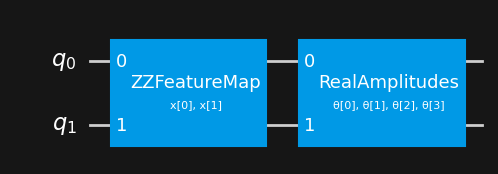

In [56]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap

# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")

We can also look at what this circuit looks like on the gate level, by calling `decompose`

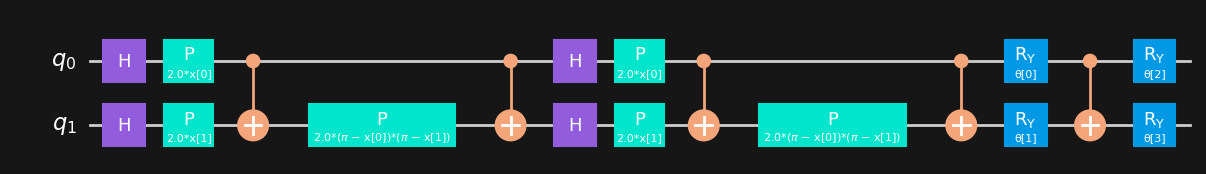

In [57]:
qc.decompose(reps=2).draw()

Next we define a parity function that maps bitstrings to 0 or 1, and pass this as a custom `interpret` parameter as we construct our QNN. We also specify an `output_shape`, which corresponds to the number of classes, i.e. possible outcomes of the (parity) mapping, and our Classification.

In [58]:
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2

So we are in position to construct our QNN

In [59]:
from qiskit_machine_learning.neural_networks import SamplerQNN

# construct QNN
sampler_qnn_runtime_sim = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sampler=runtime_sampler_simulator
)

We will add a callback function called `callback_graph`. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [60]:
from IPython.display import clear_output

# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we need to construct a Classifier based on this QNN, pass the callback and a method for classical optimization

In [61]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA

# construct classifier
sampler_classifier_runtime_sim = NeuralNetworkClassifier(
    neural_network=sampler_qnn_runtime_sim, optimizer=COBYLA(maxiter=12), callback=callback_graph
)

So we are ready to run our Classification through the QNN with Qiskit Runtime

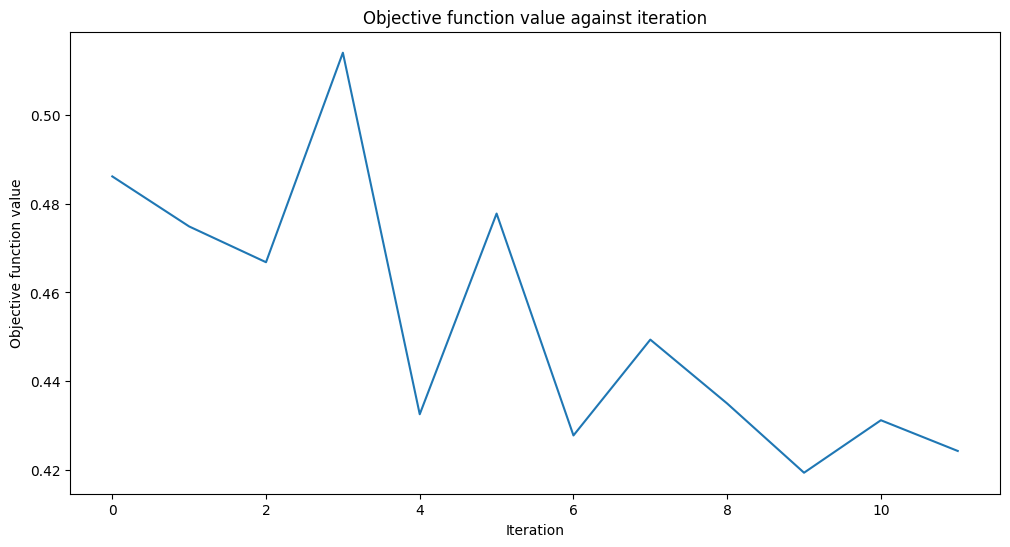

Score: 0.8 (Classification: mean accuracy)


In [62]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier_runtime_sim.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Score:",sampler_classifier_runtime_sim.score(X, y01),'(Classification: mean accuracy)')

Let's see how good it was at classifying the points we gave as input, red circles will denote points that were missed

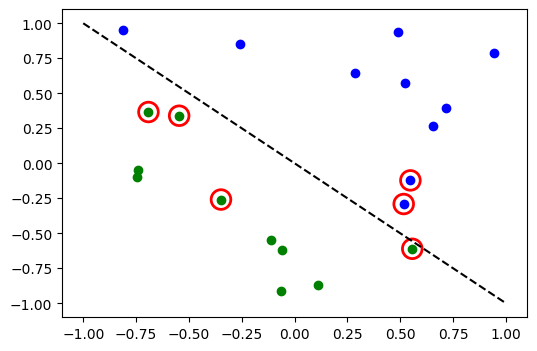

In [40]:
# evaluate data points
y_predict = sampler_classifier_runtime_sim.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Run on a real QC through Qiskit Runtime

Now that we have seen an exemplary application of a QNN through Qiskit Runtime, let us look at how we can easily do the same on a real quantum computer. In essence, we just need to change the name of the backend and make sure to pass the Sampler running on that backend to the ``SamplerQNN``

In [30]:
from qiskit_ibm_runtime import Options
real_qc = runtime_service.backend('ibm_hanoi')
real_options = Options(execution={"rep_delay": 10e-6, 'shots':400},max_execution_time=60*60)
runtime_sampler_realQC = Sampler(session=real_qc,options=real_options)

we then pass this Sampler containing the Session on a real backend to the QNN

In [31]:
sampler_qnn_realQC = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
    sampler=runtime_sampler_realQC
)

As before, we will construct a Classifier, with the only difference being the QNN that is based on is now related to an actual physical QC 

In [32]:
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA
# construct classifier
sampler_classifier_realQC = NeuralNetworkClassifier(
    neural_network=sampler_qnn_realQC, optimizer=COBYLA(maxiter=8), callback=callback_graph
)

We will now queue our QNN for training on the quantum computer. Once it hits the top of the queue, thanks to the Qiskit Runtime Session that we opened, we will see live updates of each training iteration! This is actually very exciting to see how we have the system completely to ourselves and can see our continuous progress. Make sure to try this at home! 

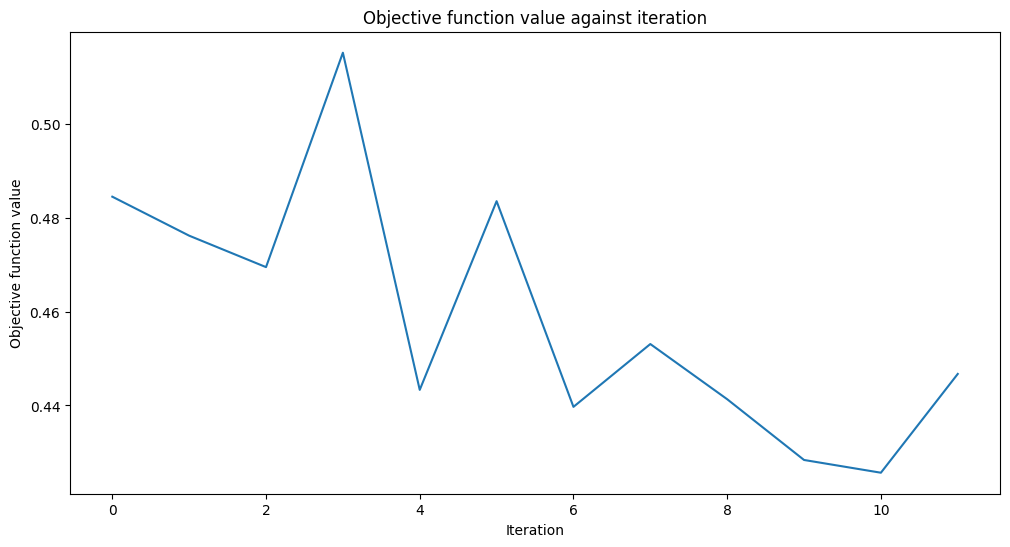

Score (Classification: mean accuracy):  0.7


In [33]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier_realQC.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
print("Score (Classification: mean accuracy): ",sampler_classifier_realQC.score(X, y01))

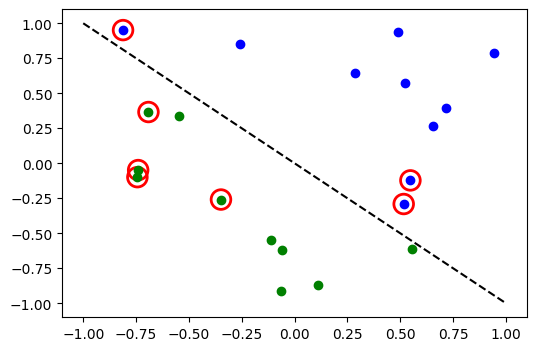

In [34]:
# evaluate data points
y_predict = sampler_classifier_realQC.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

# Sources and Resources

* IBM Quantum Insider: https://quantum-growth.edunext.io . Please use your institutional/business email to register

* [quantum-enablement.org](https://quantum-enablement.org/)

* [qiskit-ibm-runtime tutorials](https://github.com/Qiskit/qiskit-ibm-runtime/tree/main/docs/tutorials)

* [qiskit-machine-learning tutorials](https://github.com/Qiskit/qiskit-machine-learning/tree/main/docs/tutorials)

* Qiskit Runtime: [Getting started](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/getting_started.html)